# Five-Bar Linkage Workspace and Manipulability Analysis
This notebook computes forward kinematics, Jacobian, workspace, and manipulability for a 5-bar planar linkage (parallel manipulator).
Edit the link parameters and ranges to explore different geometries. Mode `+1` corresponds to the elbow-up configuration.

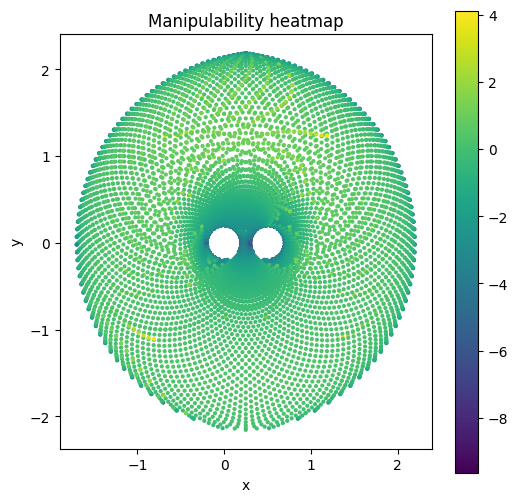

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

class FiveBarParams:
    def __init__(self, g=1.0, l1=1.0, l2=1.0, l3=1.0, l4=1.0):
        self.g = float(g)
        self.l1 = float(l1)
        self.l2 = float(l2)
        self.l3 = float(l3)
        self.l4 = float(l4)

def fk(theta1, theta2, p: FiveBarParams, mode=+1):
    C = np.array([p.l1 * np.cos(theta1), p.l1 * np.sin(theta1)])
    D = np.array([p.g + p.l2 * np.cos(theta2), p.l2 * np.sin(theta2)])
    Delta = D - C
    dx, dy = Delta
    d = np.hypot(dx, dy)
    if not (abs(p.l3 - p.l4) <= d <= (p.l3 + p.l4)):
        return (None,)*6
    psi = math.atan2(dy, dx)
    cos_arg = np.clip((p.l3**2 + d**2 - p.l4**2) / (2 * p.l3 * d), -1, 1)
    gamma = math.acos(cos_arg)
    alpha = psi + mode * gamma
    P = C + p.l3 * np.array([math.cos(alpha), math.sin(alpha)])
    x, y = P
    a1 = P - C
    a2 = P - D
    A = np.vstack([a1, a2])
    dC_dth1 = np.array([-p.l1 * np.sin(theta1), p.l1 * np.cos(theta1)])
    dD_dth2 = np.array([-p.l2 * np.sin(theta2), p.l2 * np.cos(theta2)])
    b1 = float(a1 @ dC_dth1)
    b2 = float(a2 @ dD_dth2)
    B = np.array([[b1, 0], [0, b2]])
    if abs(np.linalg.det(A)) < 1e-12:
        return x, y, C, D, None, None
    return x, y, C, D, A, B

def jacobian(theta1, theta2, p: FiveBarParams, mode=+1):
    res = fk(theta1, theta2, p, mode)
    if res[0] is None or res[4] is None:
        return None
    _, _, _, _, A, B = res
    return np.linalg.solve(A, B)

def manipulability_abs_detJ(theta1, theta2, p: FiveBarParams, mode=+1):
    J = jacobian(theta1, theta2, p, mode)
    if J is None:
        return np.nan
    return abs(np.linalg.det(J))

def sample_workspace(p, th1_range, th2_range, n1=300, n2=300, mode=+1):
    th1_vals = np.linspace(*th1_range, n1)
    th2_vals = np.linspace(*th2_range, n2)
    X, Y, W = [], [], []
    for t1 in th1_vals:
        for t2 in th2_vals:
            x, y, *_ = fk(t1, t2, p, mode)
            if x is None:
                continue
            w = manipulability_abs_detJ(t1, t2, p, mode)
            X.append(x); Y.append(y); W.append(w)
    return np.array(X), np.array(Y), np.array(W)

def plot_manipulability(X, Y, W, log=True):
    vals = W.copy()
    if log:
        eps = np.nanmin(vals[vals>0])*1e-3 if np.any(vals>0) else 1e-12
        vals = np.log(vals + eps)
    plt.figure(figsize=(6,6))
    plt.scatter(X, Y, c=vals, s=4)
    plt.gca().set_aspect('equal')
    plt.title('Manipulability heatmap')
    plt.xlabel('x'); plt.ylabel('y'); plt.colorbar(); plt.show()

# Example parameters
p = FiveBarParams(g=0.5, l1=1.2, l2=1.2, l3=1.0, l4=1.0)
X, Y, W = sample_workspace(p, (-np.pi, np.pi), (-np.pi, np.pi), n1=121, n2=121, mode=+1)
plot_manipulability(X, Y, W, log=True)

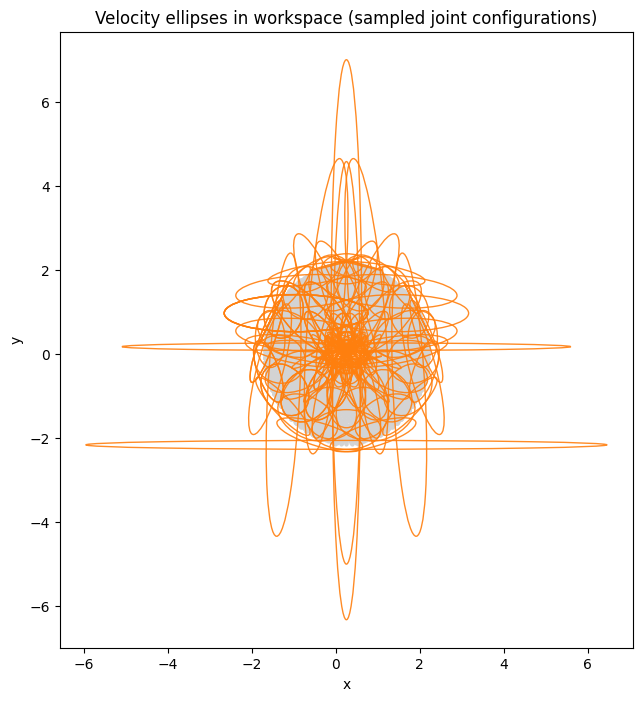

In [6]:
from matplotlib.patches import Ellipse

# Parameters for sampling and drawing
n1, n2 = 15, 15            # number of joint samples per axis (keep small to avoid clutter)
mode = +1                  # elbow-up / elbow-down
scale = 0.12 * max(np.ptp(X), np.ptp(Y))  # visual scaling for ellipse sizes

fig, ax = plt.subplots(figsize=(8,8))
# show workspace points in light gray
ax.scatter(X, Y, c='lightgray', s=4, zorder=0)

th1_vals = np.linspace(-np.pi, np.pi, n1)
th2_vals = np.linspace(-np.pi, np.pi, n2)

for t1 in th1_vals:
    for t2 in th2_vals:
        res = fk(t1, t2, p, mode)
        x, y = res[0], res[1]
        if x is None:
            continue
        J = jacobian(t1, t2, p, mode)
        if J is None:
            continue
        # velocity ellipse for unit joint velocity ball: metric = J J^T
        M = J @ J.T
        # eigen-decomposition (ascending eigenvalues)
        evals, evecs = np.linalg.eigh(M)
        if np.any(evals <= 0):
            continue
        # major/minor axes lengths (2*sqrt(eig)) scaled for plotting
        major = 2.0 * np.sqrt(evals[-1]) * scale
        minor = 2.0 * np.sqrt(evals[0]) * scale
        # angle of major axis in degrees
        major_vec = evecs[:, -1]
        angle = np.degrees(np.arctan2(major_vec[1], major_vec[0]))
        ell = Ellipse((x, y), width=major, height=minor, angle=angle,
                      edgecolor='C1', facecolor='none', alpha=0.9, lw=1.0, zorder=1)
        ax.add_patch(ell)

ax.set_aspect('equal')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('Velocity ellipses in workspace (sampled joint configurations)')
plt.show()